# Active Learning on a 2D toy example

This notebook demonstrates how to apply a variety of acquisition functions for doing active learning on a simple 2D classification problem. Both classic acquisition functions as well as a prediction-oriented one is considered. These are:
- Random
- Minimum Margin Sampling
- Variation Ratios
- Entropy
- Bayesian Active Learning by Disagreement - BALD
- Expected Predictive Information Gain - EPIG

In [1]:
import os
import types

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from src.visualization.toy_example import plot_moons, plot_multiclass, show_density_grid, show_acquisition_grid, plot_performance_curves
from src.data.toy_example import generate_moons, generate_multiclass
from src.methods.acquisition_functions import Random, VariationRatios, MinimumMargin, Entropy, BALD, EPIG
from src.methods.toy_example import run_active_learning_loop
from src.models.utils import GP_sample, combine_results

### Data generation - Binary dataset

For illustrating a variety of active learning methods a 2D toy example is considered. The specific one at hand is the non-linear classification task associated with `sklearn`'s `make_moons`-dataset. As defined below, the data configuration consists of $N_{initial} = 5$, $N_{test}=100$ and $N_{pool}=500$ data points.

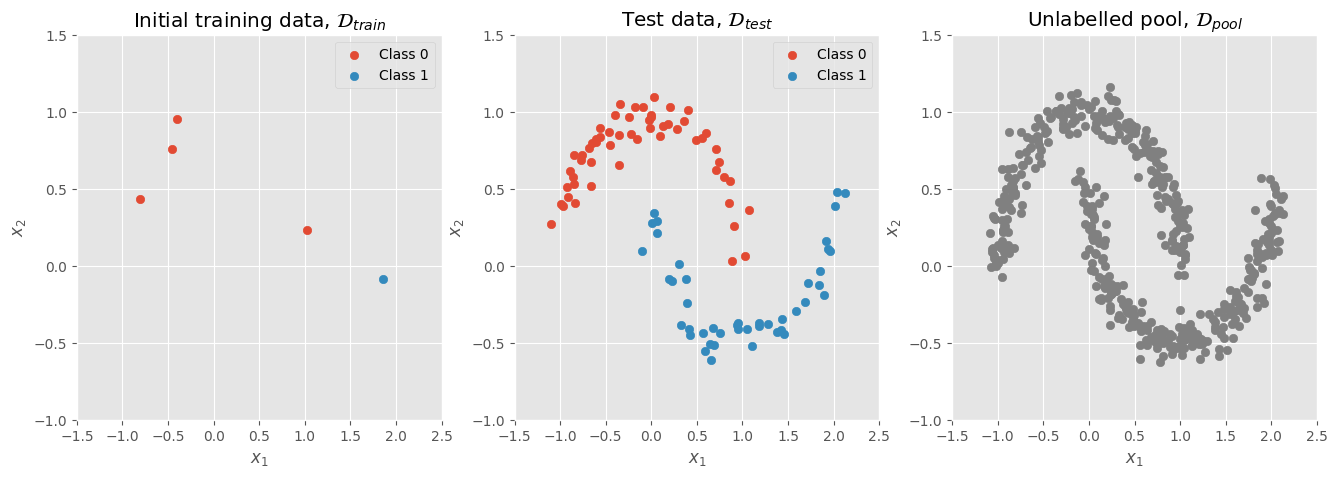

In [3]:
np.random.seed(0)

# Define dataset sizes
N_initial   = 5
N_test      = 100
N_pool      = 500
num_classes = 2

# Generate dataset partitions
Xtrain, ytrain, Xtest, ytest, Xpool, ypool = generate_moons(N_initial=N_initial, N_test=N_test, N_pool=N_pool)

# Plot the dataset partitions
plot_moons(Xtrain, ytrain, Xtest, ytest, Xpool, ypool)

### Visualizing model predictions

For optimally querying the pool for new data points, a model outputting proper uncertainty estimates is a strict requirement. For simplicity, we consider a Gaussian Process (GP) classification model and exploit `sklearn` for an easy implementation.   

In [4]:
# Define model
model           = GaussianProcessClassifier(1.0 * RBF(1.0))
model.sample    = types.MethodType( GP_sample, model )

# Train model
model.fit(Xtrain, ytrain)
# Show performance
print(f"ACCURACY\n  -> train: {model.score(Xtrain, ytrain)}\n  -> test: {model.score(Xtest, ytest)}")

ACCURACY
  -> train: 1.0
  -> test: 0.72


As is validly seen from the above results, the test performance suffers from the small size of the training data. As such, we approach selection of additional data points through active learning. In the following cell, one data point is queried by exploiting the `Entropy` acquisition function.

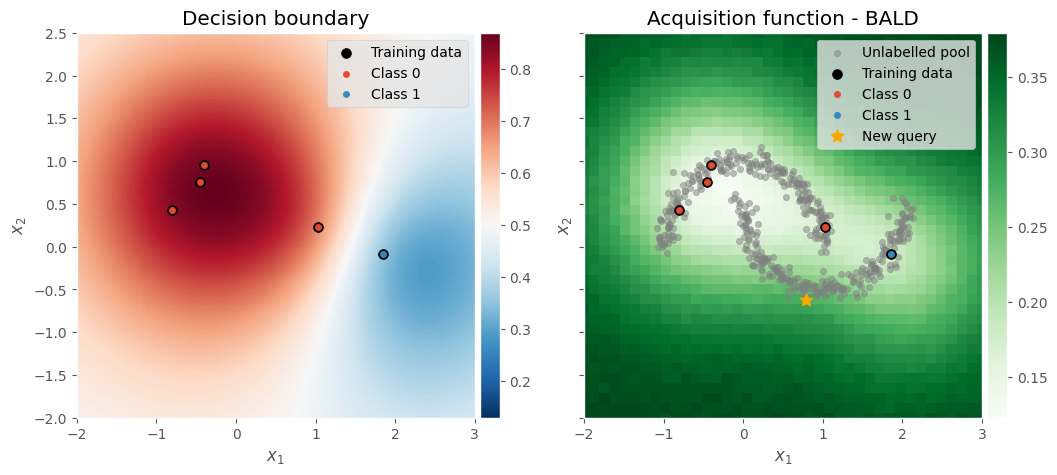

In [5]:
# Define acquisition function
acq_fun = BALD(query_n_points=None, n_samples=10000)

# Get acquisition function score and the items to query
_, query_idxs = acq_fun(Xpool, model=model)
next_query = Xpool[query_idxs[0]]


### PLOT DECISION BOUNDARY AND ACQUISITION FUNCTION ###
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

# Plot model uncertainty across grid
axs[0] = show_density_grid(model, Xtrain, Xtest, ytrain, ytest, zoom=([-2, 3], [-2, 2.5]), ax=axs[0], fig=fig)
axs[0].legend()

# Plot acquisition function across a grid
axs[1] = show_acquisition_grid(model, acq_fun, Xtrain, ytrain, Xpool, zoom=([-2, 3], [-2, 2.5]), P=40, ax=axs[1], fig=fig)
axs[1].scatter(next_query[0], next_query[1], color='orange', marker=(5, 1), s=100, label='New query')
axs[1].legend()

plt.show()

### Running the active learning loop

In [26]:
# Define dataset sizes
N_initial   = 4
N_test      = 100
N_pool      = 100
N_iter      = 20
num_classes = 2
seed        = 5

# Define acquisition function
for acq_fun in [Random(query_n_points=None), MinimumMargin(query_n_points=None), VariationRatios(query_n_points=None), Entropy(query_n_points=None), BALD(query_n_points=None)]:
    np.random.seed(seed)

    print(f"{'-'*10} RUNNING {acq_fun.name} ACQUISITION FUNCTION{'-'*10}")
    
    # Define model
    model           = GaussianProcessClassifier(1.0 * RBF(1.0))
    model.sample    = types.MethodType( GP_sample, model )

    # Generate dataset partitions
    Xtrain, ytrain, Xtest, ytest, Xpool, ypool = generate_moons(N_initial=N_initial, N_test=N_test, N_pool=N_pool)

    # Run active learning loop
    model, performance, Xtrain, ytrain = run_active_learning_loop(
        model,
        acq_fun=acq_fun,
        Xtrain=Xtrain, Xtest=Xtest, Xpool=Xpool, 
        ytrain=ytrain, ytest=ytest, ypool=ypool,
        n_iterations=N_iter,
        save_fig=True, 
        animate=True, fps=1,
        num_classes=num_classes,
        seed=seed
    )

---------- RUNNING Random ACQUISITION FUNCTION----------
Train acc.: 1.00 |   Test acc.: 0.67 |   |ytrain|: 4 points   |   Remaining pool: 99 points   |   Query: [-0.54, 0.70]
Train acc.: 1.00 |   Test acc.: 0.78 |   |ytrain|: 5 points   |   Remaining pool: 98 points   |   Query: [0.77, -0.38]
Train acc.: 1.00 |   Test acc.: 0.82 |   |ytrain|: 6 points   |   Remaining pool: 97 points   |   Query: [-0.15, 0.98]
Train acc.: 1.00 |   Test acc.: 0.81 |   |ytrain|: 7 points   |   Remaining pool: 96 points   |   Query: [1.83, -0.06]
Train acc.: 1.00 |   Test acc.: 0.88 |   |ytrain|: 8 points   |   Remaining pool: 95 points   |   Query: [1.03, -0.49]
Train acc.: 1.00 |   Test acc.: 0.88 |   |ytrain|: 9 points   |   Remaining pool: 94 points   |   Query: [0.81, 0.50]
Train acc.: 1.00 |   Test acc.: 0.88 |   |ytrain|: 10 points   |   Remaining pool: 93 points   |   Query: [0.39, -0.12]
Train acc.: 1.00 |   Test acc.: 0.92 |   |ytrain|: 11 points   |   Remaining pool: 92 points   |   Query: [-1.

c:\users\alber\desktop\dtu\3_hcai\activebayesiandeeplearning\abdl\src\methods\acquisition_functions.py:116: RuntimeWarning: divide by zero encountered in log
  disagreement_term   = (posterior_samples * np.log(posterior_samples)).sum(axis=0).mean(axis=0)
c:\users\alber\desktop\dtu\3_hcai\activebayesiandeeplearning\abdl\src\methods\acquisition_functions.py:116: RuntimeWarning: invalid value encountered in multiply
  disagreement_term   = (posterior_samples * np.log(posterior_samples)).sum(axis=0).mean(axis=0)


Train acc.: 1.00 |   Test acc.: 1.00 |   |ytrain|: 20 points   |   Remaining pool: 83 points   |   Query: [1.63, -0.19]


c:\users\alber\desktop\dtu\3_hcai\activebayesiandeeplearning\abdl\src\methods\acquisition_functions.py:116: RuntimeWarning: divide by zero encountered in log
  disagreement_term   = (posterior_samples * np.log(posterior_samples)).sum(axis=0).mean(axis=0)
c:\users\alber\desktop\dtu\3_hcai\activebayesiandeeplearning\abdl\src\methods\acquisition_functions.py:116: RuntimeWarning: invalid value encountered in multiply
  disagreement_term   = (posterior_samples * np.log(posterior_samples)).sum(axis=0).mean(axis=0)


Train acc.: 1.00 |   Test acc.: 1.00 |   |ytrain|: 21 points   |   Remaining pool: 82 points   |   Query: [0.33, -0.36]


c:\users\alber\desktop\dtu\3_hcai\activebayesiandeeplearning\abdl\src\methods\acquisition_functions.py:116: RuntimeWarning: divide by zero encountered in log
  disagreement_term   = (posterior_samples * np.log(posterior_samples)).sum(axis=0).mean(axis=0)
c:\users\alber\desktop\dtu\3_hcai\activebayesiandeeplearning\abdl\src\methods\acquisition_functions.py:116: RuntimeWarning: invalid value encountered in multiply
  disagreement_term   = (posterior_samples * np.log(posterior_samples)).sum(axis=0).mean(axis=0)


Train acc.: 1.00 |   Test acc.: 1.00 |   |ytrain|: 22 points   |   Remaining pool: 81 points   |   Query: [-1.19, 0.21]


c:\users\alber\desktop\dtu\3_hcai\activebayesiandeeplearning\abdl\src\methods\acquisition_functions.py:116: RuntimeWarning: divide by zero encountered in log
  disagreement_term   = (posterior_samples * np.log(posterior_samples)).sum(axis=0).mean(axis=0)
c:\users\alber\desktop\dtu\3_hcai\activebayesiandeeplearning\abdl\src\methods\acquisition_functions.py:116: RuntimeWarning: invalid value encountered in multiply
  disagreement_term   = (posterior_samples * np.log(posterior_samples)).sum(axis=0).mean(axis=0)


Train acc.: 1.00 |   Test acc.: 1.00 |   |ytrain|: 23 points   |   Remaining pool: 80 points   |   Query: [0.45, 0.85]
Train acc.: 1.00   |   Test acc.: 1.00   |   |ytrain|: 24 points  |


### Generalizing for multiclass problems

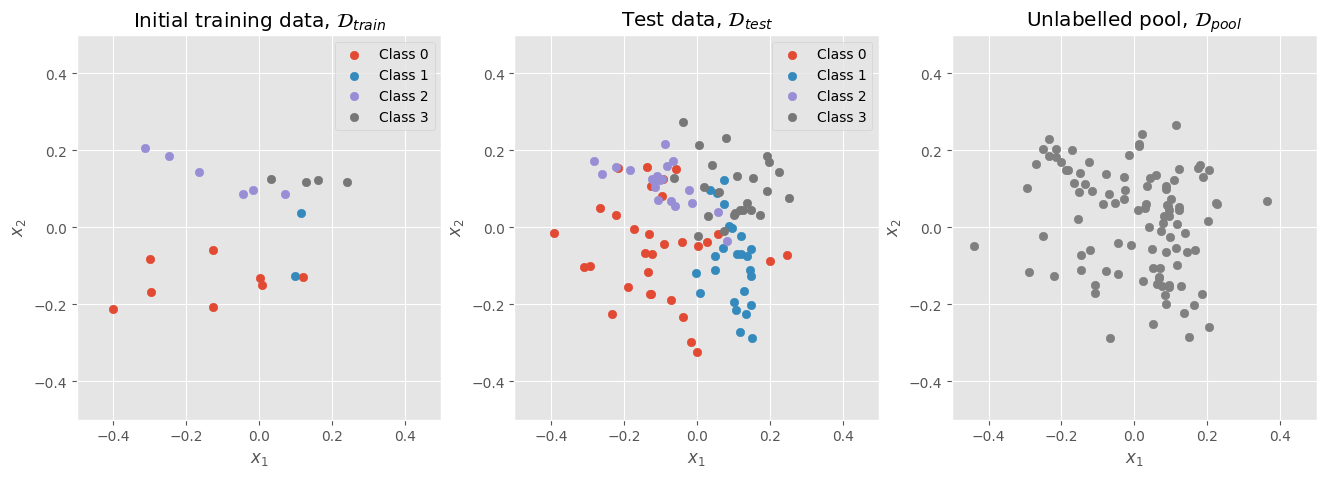

ACCURACY
  -> train: 0.9
  -> test: 0.58


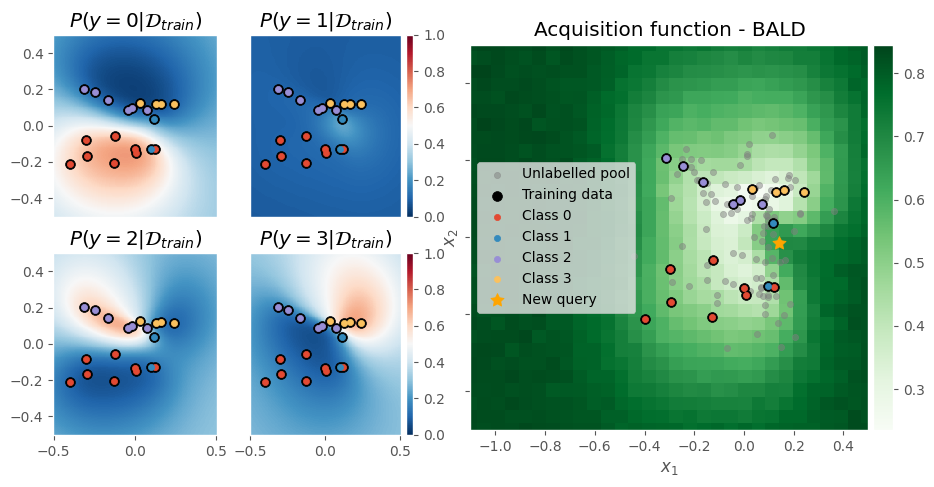

In [6]:
np.random.seed(0)

# Define dataset sizes
N_initial   = 20
N_test      = 100
N_pool      = 100
num_classes = 4

# Generate dataset partitions
Xtrain, ytrain, Xtest, ytest, Xpool, ypool = generate_multiclass(N_initial=N_initial, N_test=N_test, N_pool=N_pool, num_classes=num_classes, noise=0.1)
assert all([i in ytrain for i in np.arange(4)]), "Not all labels are present in initial pool..."

# Plot the dataset partitions
plot_multiclass(Xtrain, ytrain, Xtest, ytest, Xpool, ypool, num_classes=num_classes)

# Define model
model           = GaussianProcessClassifier(1.0 * RBF(1.0))
model.sample    = types.MethodType( GP_sample, model )

# Train model
model.fit(Xtrain, ytrain)
# Show performance
print(f"ACCURACY\n  -> train: {model.score(Xtrain, ytrain)}\n  -> test: {model.score(Xtest, ytest)}")

# Define acquisition function
acq_fun = BALD(query_n_points=None, n_samples=1000)

# Get acquisition function score and the items to query
_, query_idxs = acq_fun(Xpool, model=model)
next_query = Xpool[query_idxs[0]]


### PLOT DECISION BOUNDARY AND ACQUISITION FUNCTION ###
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

# Plot model uncertainty across grid
axs[0] = show_density_grid(model, Xtrain, Xtest, ytrain, ytest, zoom=([-0.5, 0.5], [-0.5, 0.5]), ax=axs[0], fig=fig, num_classes=num_classes)
# axs[0].legend()

# Plot acquisition function across a grid
axs[1] = show_acquisition_grid(model, acq_fun, Xtrain, ytrain, Xpool, zoom=([-1.1, 0.5], [-0.5, 0.5]), P=30, ax=axs[1], fig=fig, num_classes=num_classes)
axs[1].scatter(next_query[0], next_query[1], color='orange', marker=(5, 1), s=100, label='New query')
axs[1].legend(loc='center left')

plt.show()

In [25]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# Define dataset sizes
N_initial   = 10
N_test      = 100
N_pool      = 100
N_iter      = 20
num_classes = 4
seed        = 5

# Define acquisition function
for acq_fun in [Random(query_n_points=None), MinimumMargin(query_n_points=None), VariationRatios(query_n_points=None), Entropy(query_n_points=None), BALD(query_n_points=None)]:
    np.random.seed(seed)

    print(f"{'-'*10} RUNNING {acq_fun.name} ACQUISITION FUNCTION{'-'*10}")
    
    # Define model
    model           = GaussianProcessClassifier(1.0 * RBF(1.0))
    model.sample    = types.MethodType( GP_sample, model )

    # Generate dataset partitions
    Xtrain, ytrain, Xtest, ytest, Xpool, ypool = generate_multiclass(N_initial=N_initial, N_test=N_test, N_pool=N_pool, num_classes=num_classes, noise=0.1)
    assert all([i in ytrain for i in np.arange(4)]), "Not all labels are present in initial pool..."

    # Run active learning loop
    model, performance, Xtrain, ytrain = run_active_learning_loop(
        model,
        acq_fun=acq_fun,
        Xtrain=Xtrain, Xtest=Xtest, Xpool=Xpool, 
        ytrain=ytrain, ytest=ytest, ypool=ypool,
        n_iterations=N_iter,
        save_fig=True, 
        animate=True, fps=1,
        num_classes=num_classes,
        zoom=([-1.1, 0.5], [-0.5, 0.5]),
        seed=seed,
    )

---------- RUNNING Random ACQUISITION FUNCTION----------
Train acc.: 1.00 |   Test acc.: 0.71 |   |ytrain|: 10 points   |   Remaining pool: 99 points   |   Query: [-0.11, 0.10]
Train acc.: 1.00 |   Test acc.: 0.77 |   |ytrain|: 11 points   |   Remaining pool: 98 points   |   Query: [0.12, -0.13]
Train acc.: 1.00 |   Test acc.: 0.77 |   |ytrain|: 12 points   |   Remaining pool: 97 points   |   Query: [-0.15, 0.19]
Train acc.: 1.00 |   Test acc.: 0.77 |   |ytrain|: 13 points   |   Remaining pool: 96 points   |   Query: [-0.08, 0.11]
Train acc.: 1.00 |   Test acc.: 0.76 |   |ytrain|: 14 points   |   Remaining pool: 95 points   |   Query: [0.10, 0.08]
Train acc.: 1.00 |   Test acc.: 0.77 |   |ytrain|: 15 points   |   Remaining pool: 94 points   |   Query: [0.11, -0.13]
Train acc.: 1.00 |   Test acc.: 0.77 |   |ytrain|: 16 points   |   Remaining pool: 93 points   |   Query: [-0.04, -0.29]
Train acc.: 1.00 |   Test acc.: 0.76 |   |ytrain|: 17 points   |   Remaining pool: 92 points   |   Quer

### Performance vs. training set size

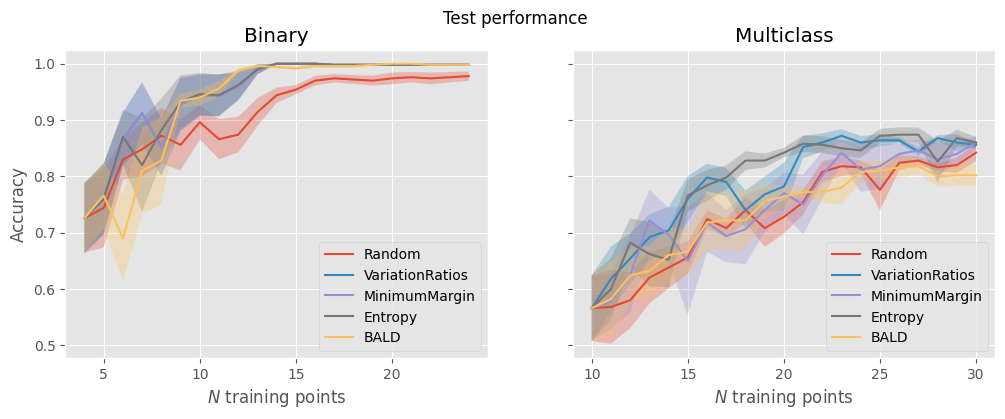

In [27]:
acq_functions = ['Random', 'VariationRatios', 'MinimumMargin', 'Entropy', 'BALD']
train_results, test_results = combine_results(acq_functions=acq_functions, seeds=[0, 1, 3, 4, 5])

fig = plot_performance_curves(test_results, acq_functions=acq_functions)
fig.suptitle('Test performance')
plt.show()